# Algorithms

In this tutorial, we will explore the general philosophy behind algorithms provided in this framework and we will end with a look at implementing your own algorithms from scratch, whilst maintaining compatibility with the framework. CIFY provides algorithms for swarm intelligence and evolutionary computation and all algorithms return statistics in the form of a Pandas DataFrame. We'll start by looking at particle swarm optimization (PSO), but first, we must import cify and set a seed for all stochastic operations.

In [1]:
# To install cify via pip:
# ! pip install cify
import cify as ci

ci.set_seed(0)

CIFY: internal seed successfully set to: '0'


## PSO

Particle Swarm Optimization (PSO) algorithms use one or more swarms of particles to solve an objective function. The particles have position and velocity update operators that determine how to update their position
and velocity at the end of each iteration. The velocity update operator, typically prefixed with `*_vel_update`, determines how the trajectory of a particle in search space is affected. Below are a few examples of optimizing the rosenbrock objective function using a couple PSO metaheuristics. First, we'll import the algorithms and define an objective function.

In [2]:
from cify.si.pso.algorithm import PSO, InertiaWeightPSO

# Define objective function.
obj_func = ci.get_objective_function('rosenbrock', ci.Optimization.Min, 10)

The standard PSO algorithm with three swarms:

In [4]:
pso = PSO(obj_func, swarms=[
    ci.get_swarm(n_particles=50, obj_func=obj_func),
    ci.get_swarm(n_particles=30, obj_func=obj_func),
    ci.get_swarm(n_particles=20, obj_func=obj_func),
])

# Execute and return the statistics of the last five iterations.
pso.execute(100)
pso.statistics.tail(5)

100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


,best,worst,mean,stdev,global_optimum,n_evaluations
iteration,,,,,,
96,111.703958,10033.546738,4648.041998,2203.011241,111.703958,8503
97,111.703958,11522.656332,4395.894601,2385.997594,111.703958,8503
98,111.703958,9709.636204,3988.904745,2162.019298,111.703958,8503
99,111.703958,9824.141424,4235.712319,2073.313266,111.703958,8503
100,111.703958,11972.964051,4318.737118,2118.621926,111.703958,8503


The performance of the standard PSO was ok, but not great. Let's try using the `InertiaWeightPSO` algorithm instead. This algorithm uses a different velocity update operator that gives each particle inertia in its journey through the search space. We could also just use the `PSO` algorithm and make it use the `inertia_weight_vel_update` operator. Remember, PSO velocity update operators are stored in `cify.velocity_updates`.

In [5]:
# This is just for demonstration purposes. We'll use inertia_pso to optimize the objective function.
using_standard_pso = PSO(obj_func=obj_func,
                         swarms=[ci.get_swarm(obj_func=obj_func)],
                         velocity_update=ci.velocity_updates.inertia_weight_vel_update)

# Using the InertiaWeightPSO class
inertia_pso = InertiaWeightPSO(obj_func=obj_func, swarms=[ci.get_swarm(obj_func=obj_func)])

inertia_pso.execute(100)
inertia_pso.statistics.tail(5)

100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


,best,worst,mean,stdev,global_optimum,n_evaluations
iteration,,,,,,
96,27.459453,10946.777377,4405.792193,2542.205149,26.964811,5460
97,27.331610,9606.118944,4086.874835,2223.051825,26.964811,5457
98,25.839312,8501.609323,3970.045161,2058.048869,25.839312,5459
99,26.359693,10492.288225,3837.837926,2340.602586,25.839312,5465
100,25.026685,8766.201689,4508.877989,2016.702601,25.026685,5459


That's better, we've managed to gain a reasonable improvement over the standard PSO. Let's try tuning the operators a little. We'll also use 3 swarms with 75 particles each, and get them using the `get_swarms` utility method. To examine the performance of this approach, we'll plot the `global_optimum` using matplotlib.

100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


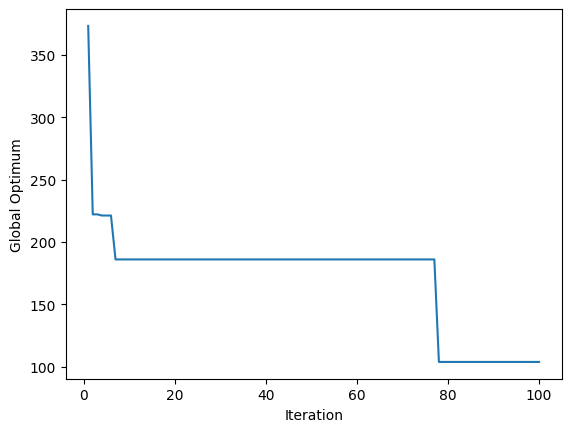

In [6]:
import matplotlib.pyplot as plt

tuned_pso = InertiaWeightPSO(obj_func=obj_func,
                             swarms=ci.get_swarms(3, 75, obj_func=obj_func),
                             velocity_params = {'w': 0.82, 'c1':1.12, 'c2':1.8},
                             )

tuned_pso.execute(100)
plt.plot(tuned_pso.statistics['global_optimum'])
plt.xlabel('Iteration')
plt.ylabel('Global Optimum')
plt.show()

With all those particles to simulate (3 x 75 = 225), that took a a bit longer to run. Luckily, we have some acceptable results as indicated in the graph above. But, if we look at the results of our final iteration, we have not improved at all over the previous approaches.

In [7]:
tuned_pso.statistics.tail(1)

,best,worst,mean,stdev,global_optimum,n_evaluations
iteration,,,,,,
100,1050.879232,11703.089433,4297.516689,1964.308719,103.682729,35776


## GA

Genetic algorithms might be able to solve the Rosenbrock problem better than the previous PSO attempts. We'll try just one approach for 100 iterations. Have a look through the API documentation for more genetic algorithm approaches, in particular, look through the evolutionary operators as adjusting these parameters will lead to the biggest improvements. We'll use linear crossover to ensure our floating point input variables are blended. There are a range of other operators that perform blending in different ways. Some of the other operators, such as `uniform_crossover` or `npoint_crossover` are for discrete input variables. Once again, the API documentation is your friend.

In [11]:
from cify.ec.ga.algorithm import GA

ga = GA(obj_func=obj_func,
        populations=ci.get_populations(3, 50, obj_func=obj_func),
        # crossover_operator=ci.operators.linear_crossover,
        )

ga.execute(100)
ga.statistics.tail(1)

100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


,best,worst,mean,stdev,global_optimum,n_evaluations
iteration,,,,,,
100,139.706543,1163.962239,283.416151,125.221247,34.484795,1801


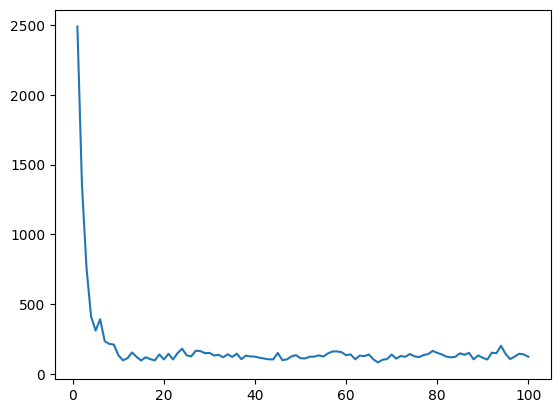

In [12]:
import matplotlib.pyplot as plt

plt.plot(ga.statistics['stdev'])
plt.show()

## DE

Differential evolution takes a different approach to finding optimal solutions. Let's see how a DE algorithm compares to the previous approaches.

In [8]:
from cify.ec.de.algorithm import DE

de = DE(obj_func=obj_func, populations=[ci.get_population(50, obj_func=obj_func)])

de.execute(100)
de.statistics.tail(5)

100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


,best,worst,mean,stdev,global_optimum,n_evaluations
iteration,,,,,,
96,0.209123,0.703089,0.466061,0.123154,0.163842,400
97,0.209123,0.703089,0.434530,0.111184,0.163842,400
98,0.201311,0.703089,0.389530,0.111078,0.163842,400
99,0.201311,0.543802,0.359623,0.102018,0.163842,400
100,0.170072,0.543802,0.327667,0.101395,0.163842,400


Wow, so far that's the best approach for this problem. Let's see how the global optimum changed with each iteration.

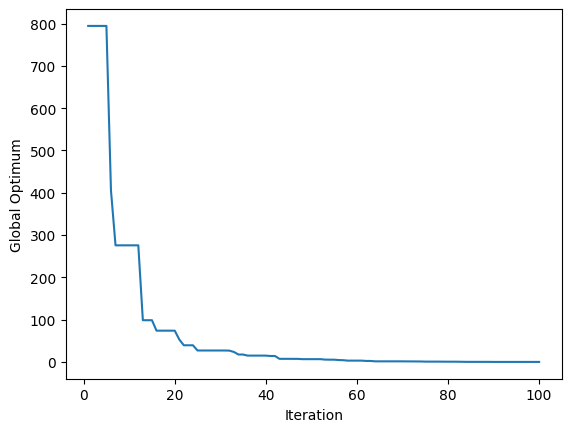

In [9]:
plt.plot(de.statistics['global_optimum'])
plt.xlabel('Iteration')
plt.ylabel('Global Optimum')
plt.show()

As is the case with all the other metaheuristics, there are different operators that can be used to further tune the behavior of the DE algorithm. They are located in `cify.target_vectors` and `cify.trial_vectors`
for different target vector selection approaches and trial vector creation approaches respectively.

## Custom Algorithm

It's also possible to define custom algorithms / metaheuristics. All we need to do is create a class that uses `cify.Algorithm` as its base class and overrides the `do_iteration` method. If you wanted to use the components of a certain paradigm, it is better practice to use the generic algorithm from that paradigm as the base class instead.

Our custom PSO implementation is going to use the `uniform_crossover` operator from the evolutionary computation package to perform discrete uniform crossover between random pairs of particles before doing the standard
iteration routine. We'll call it `EvoPSO` since it blends a little bit of evolutionary computation with particle swarm intelligence.

In [10]:
class EvoPSO(PSO):
    def __int__(self, **kwargs):
        super().__init__(**kwargs)


    def do_iteration(self):

        for swarm in self.swarms:
            for i in range(int(len(swarm) / 2)):
                particles = ci.get_rng().choice(swarm.agents, size=2, replace=False)
                swarm.remove(particles)
                swarm.append(ci.operators.uniform_crossover(particles))

        return super().do_iteration()

In [11]:
evo_pso = EvoPSO(obj_func=obj_func, swarms=[ci.get_swarm(50, obj_func=obj_func)])

evo_pso.execute(100)
evo_pso.statistics.tail(5)

100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


,best,worst,mean,stdev,global_optimum,n_evaluations
iteration,,,,,,
96,1097.248168,10895.017570,4410.627303,2363.715753,203.536983,5651
97,1299.336260,10931.679346,4316.117330,2002.327570,203.536983,5651
98,1159.129642,10725.914508,4641.166852,2241.082033,203.536983,5651
99,714.747290,10936.796737,4536.682885,1926.061391,203.536983,5651
100,1353.783962,13709.697023,4731.920196,2393.691847,203.536983,5651


As we can see from the final five iterations, this approach was not a good one. The crossing over of input variables must be greatly sacrificing exploitation for exploration in the search process.

In [1]:
plt.plot(evo_pso.statistics['global_optimum'])

NameError: name 'plt' is not defined